In [1]:
import sys
sys.path.append('..')

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from pepper import TidySimulationFdfd

[21:42:41] INFO     Using client version: 1.9.0                                                     ]8;id=442059;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=58372;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/__init__.py#115\115]8;;\

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# # compute quantities based on geometry parameters
# x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
# y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
# wg_insert_x = ring_radius + wg_spacing
# wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.
# compute quantities based on geometry parameters
x_span = 2*wg_spacing + buffer
y_span = ring_radius + buffer
wg_insert_x = wg_spacing
wg_center_y = 0#ring_radius + couple_width + wg_width/2.

In [3]:
# wavelength range of interest
lambda_beg = 0.4
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

min_steps_per_wvl = 30
run_time = 1e-11

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

In [6]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0),
    structures=[background_box, waveguide],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic())
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0])
mode_data = mode_solver.solve()

           WARNING  No sources in simulation.                                                     ]8;id=258985;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=882106;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/components/simulation.py#519\519]8;;\

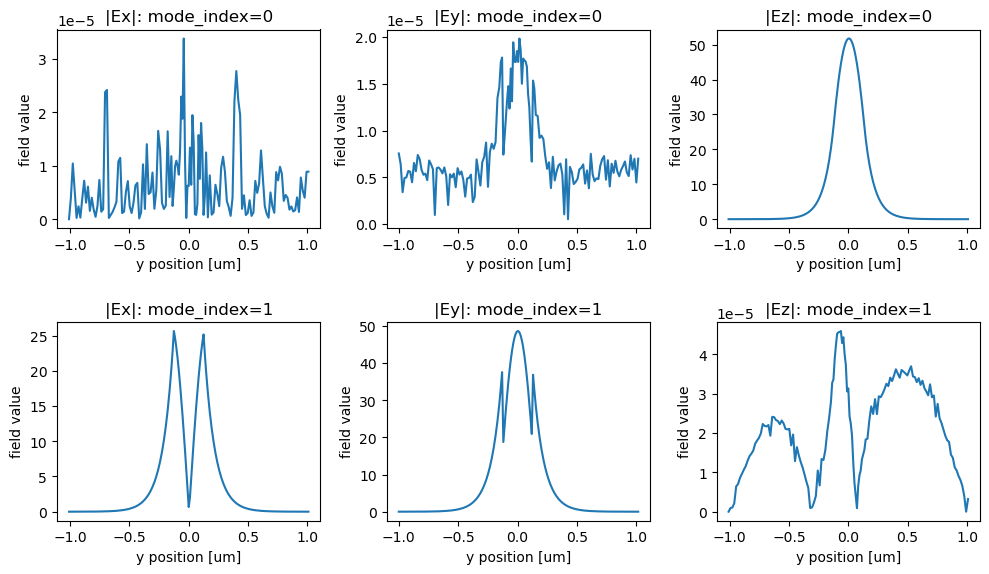

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
mode_data.Ex.sel(mode_index=0, f=freq0).abs.plot(ax=ax1)
mode_data.Ey.sel(mode_index=0, f=freq0).abs.plot(ax=ax2)
mode_data.Ez.sel(mode_index=0, f=freq0).abs.plot(ax=ax3)
mode_data.Ex.sel(mode_index=1, f=freq0).abs.plot(ax=ax4)
mode_data.Ey.sel(mode_index=1, f=freq0).abs.plot(ax=ax5)
mode_data.Ez.sel(mode_index=1, f=freq0).abs.plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

In [8]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+',
    num_freqs=11,  # using 11 (Chebyshev) points to approximate frequency dependence
)

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')


# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(lambda_beg, lambda_end, 1001)
freqs_measure = td.C_0 / lambdas_measure[::-1]

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor = mode_monitor.copy(update=dict(center = [+wg_insert_x, wg_center_y, 0]))

In [10]:
# create simulation
sim = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0),
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    shutoff=1e-9,
)

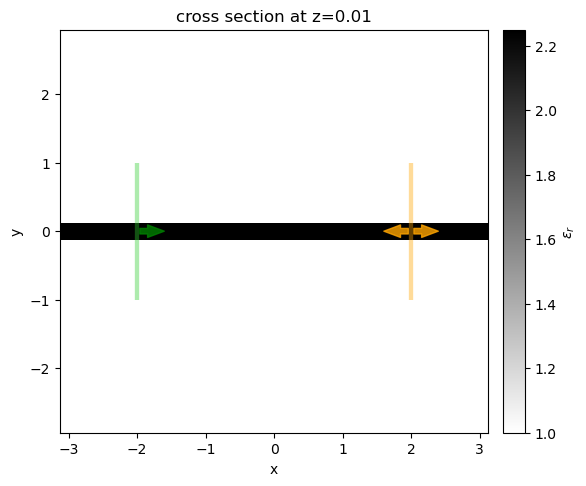

In [11]:
# plot the two simulations
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sim.plot_eps(z=0.01, ax=ax)
plt.show()

In [12]:
sim2 = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0),
    structures=[background_box, waveguide],
    #sources=[mode_source],
    #monitors=[field_monitor, mode_monitor],
    run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
)

[21:42:44] WARNING  No sources in simulation.                                                     ]8;id=718587;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=667363;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/components/simulation.py#519\519]8;;\

In [13]:
sim_fdfd = TidySimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0),
    structures=[background_box, waveguide],
    #sources=[mode_source],
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
)

           WARNING  No sources in simulation.                                                     ]8;id=381699;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=231522;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/components/simulation.py#519\519]8;;\